# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [34]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/myuser/mlfs-book


In [35]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [36]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 23, 19, 36, 12855)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [37]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-17 23:19:36,029 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 23:19:36,036 INFO: Initializing external client
2025-11-17 23:19:36,037 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 23:19:36,780 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 23:19:37,715 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272004


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [38]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=5,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-17 23:19:43,763 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/492918 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/121005 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25532 elapsed<00:00 remaining<?

In [39]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.633173E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [40]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data=batch_data.sort_values('date', ascending=False)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
recent_df = air_quality_fg.filter(
    (air_quality_fg.city == city) &
    (air_quality_fg.street == street)
).read()
recent_df = recent_df.sort_values('date', ascending=False)
recent_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.63s) 


,date,pm25,pm25_lag1,pm25_lag2,pm25_lag3,country,city,street,url
1998,2025-11-17 00:00:00+00:00,19.00,5.000000,8.000000,9.000000,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
1997,2025-11-16 00:00:00+00:00,5.00,8.000000,9.000000,2.630000,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
1996,2025-11-15 00:00:00+00:00,8.00,9.000000,2.630000,1.350000,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
1995,2025-11-14 00:00:00+00:00,9.00,2.630000,1.350000,0.880000,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
689,2025-11-06 00:00:00+00:00,2.63,1.350000,0.880000,0.430000,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
...,...,...,...,...,...,...,...,...,...
1236,2020-03-04 00:00:00+00:00,2.22,2.410000,1.800000,5.650000,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
228,2020-03-03 00:00:00+00:00,2.41,1.800000,5.650000,4.500000,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
1999,2020-03-02 00:00:00+00:00,1.80,5.650000,4.500000,3.516882,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
2001,2020-03-01 00:00:00+00:00,5.65,4.500000,3.516882,3.516882,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789


In [41]:
import datetime
import pandas as pd

batch_data['pm25_lag1'] = 0.0
batch_data['pm25_lag2'] = 0.0
batch_data['pm25_lag3'] = 0.0
batch_data['predicted_pm25'] = 0.0


feature_cols = ['pm25_lag1', 'pm25_lag2', 'pm25_lag3',
                'temperature_2m_mean', 'precipitation_sum',
                'wind_speed_10m_max', 'wind_direction_10m_dominant']

batch_data = batch_data.sort_values('date').reset_index(drop=True)

recent_pm25_list = recent_df['pm25'].tolist()

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [42]:
for idx in range(len(batch_data)):

    if idx == 0:
        
        batch_data.at[idx, 'pm25_lag1'] = recent_pm25_list[0]
        batch_data.at[idx, 'pm25_lag2'] = recent_pm25_list[1]
        batch_data.at[idx, 'pm25_lag3'] = recent_pm25_list[2]
    elif idx == 1:
       
        batch_data.at[idx, 'pm25_lag1'] = batch_data.at[idx-1, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag2'] = recent_pm25_list[0]
        batch_data.at[idx, 'pm25_lag3'] = recent_pm25_list[1]
    elif idx == 2:
       
        batch_data.at[idx, 'pm25_lag1'] = batch_data.at[idx-1, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag2'] = batch_data.at[idx-2, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag3'] = recent_pm25_list[0]
    else:
  
        batch_data.at[idx, 'pm25_lag1'] = batch_data.at[idx-1, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag2'] = batch_data.at[idx-2, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag3'] = batch_data.at[idx-3, 'predicted_pm25']

  
    X = batch_data.iloc[[idx]][feature_cols]

    
    prediction = retrieved_xgboost_model.predict(X)
    batch_data.at[idx, 'predicted_pm25'] = prediction[0]

batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25
0,2025-11-19 00:00:00+00:00,4.30,0.0,24.724951,317.950867,dublin,19.000000,5.000000,8.000000,6.370619
1,2025-11-20 00:00:00+00:00,5.00,0.0,18.775303,327.528839,dublin,6.370619,19.000000,5.000000,4.511424
2,2025-11-21 00:00:00+00:00,5.70,0.0,13.849477,207.897171,dublin,4.511424,6.370619,19.000000,5.699168
3,2025-11-22 00:00:00+00:00,7.95,0.0,16.450069,246.801392,dublin,5.699168,4.511424,6.370619,3.196717
4,2025-11-23 00:00:00+00:00,7.80,0.0,21.349546,264.193359,dublin,3.196717,5.699168,4.511424,3.156471


In [43]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   pm25_lag1                    5 non-null      float64                
 7   pm25_lag2                    5 non-null      float64                
 8   pm25_lag3                    5 non-null      float64                
 9   predicted_pm25               5 non-null      float64                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [44]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,4.30,0.0,24.724951,317.950867,dublin,19.000000,5.000000,8.000000,6.370619,Rathfarnham Road,ireland,1
1,2025-11-20 00:00:00+00:00,5.00,0.0,18.775303,327.528839,dublin,6.370619,19.000000,5.000000,4.511424,Rathfarnham Road,ireland,2
2,2025-11-21 00:00:00+00:00,5.70,0.0,13.849477,207.897171,dublin,4.511424,6.370619,19.000000,5.699168,Rathfarnham Road,ireland,3
3,2025-11-22 00:00:00+00:00,7.95,0.0,16.450069,246.801392,dublin,5.699168,4.511424,6.370619,3.196717,Rathfarnham Road,ireland,4
4,2025-11-23 00:00:00+00:00,7.80,0.0,21.349546,264.193359,dublin,3.196717,5.699168,4.511424,3.156471,Rathfarnham Road,ireland,5


In [45]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   pm25_lag1                    5 non-null      float64                
 7   pm25_lag2                    5 non-null      float64                
 8   pm25_lag3                    5 non-null      float64                
 9   predicted_pm25               5 non-null      float64                
 10  street

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

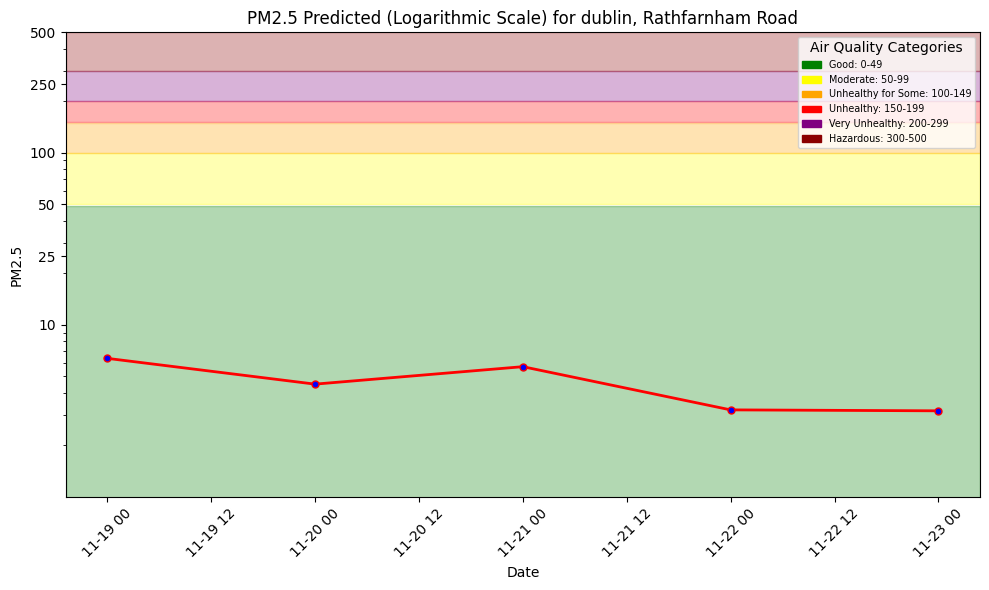

In [46]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [47]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [48]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272004/fs/1258602/fg/1718908


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272004/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-17 23:20:18,843 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 23:20:22,036 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 23:22:20,389 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 23:22:20,600 INFO: Waiting for log aggregation to finish.
2025-11-17 23:22:32,719 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [49]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.70s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,4.3,0.0,24.724951,317.950867,dublin,19.0,5.0,8.0,6.370619,Rathfarnham Road,ireland,1


In [55]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df = air_quality_df.sort_values(by=['date'], ascending=True)
air_quality_df = air_quality_df.tail(10)
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.74s) 


,date,pm25,pm25_lag1,pm25_lag2,pm25_lag3,country,city,street,url
110,2025-11-01 00:00:00+00:00,1.12,1.50,1.10,1.23,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
1727,2025-11-02 00:00:00+00:00,0.88,1.12,1.50,1.10,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
856,2025-11-03 00:00:00+00:00,0.43,0.88,1.12,1.50,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
723,2025-11-04 00:00:00+00:00,0.88,0.43,0.88,1.12,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
121,2025-11-05 00:00:00+00:00,1.35,0.88,0.43,0.88,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
689,2025-11-06 00:00:00+00:00,2.63,1.35,0.88,0.43,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
1995,2025-11-14 00:00:00+00:00,9.00,2.63,1.35,0.88,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
1996,2025-11-15 00:00:00+00:00,8.00,9.00,2.63,1.35,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
1997,2025-11-16 00:00:00+00:00,5.00,8.00,9.00,2.63,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789
1998,2025-11-17 00:00:00+00:00,19.00,5.00,8.00,9.00,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789


In [56]:
features_df = weather_fg.read()
features_df = features_df.sort_values(by=['date'], ascending=True)
features_df = features_df.tail(20)
features_df
batch_hincast = pd.merge(air_quality_df, features_df, on="date")
batch_hincast
batch_hincast.info()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         7 non-null      datetime64[us, Etc/UTC]
 1   pm25                         7 non-null      float32                
 2   pm25_lag1                    7 non-null      float32                
 3   pm25_lag2                    7 non-null      float32                
 4   pm25_lag3                    7 non-null      float32                
 5   country                      7 non-null      object                 
 6   city_x                       7 non-null      object                 
 7   street                       7 non-null      object                 
 8   url                          7 non-null      object                 

In [57]:
X = batch_hincast[feature_cols]
predictions  = retrieved_xgboost_model.predict(X)
batch_hincast['predicted_pm25']=predictions
hindcast_df = batch_hincast.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,pm25,pm25_lag1,pm25_lag2,pm25_lag3,country,city_x,street,url,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city_y,predicted_pm25
0,2025-11-04 00:00:00+00:00,0.88,0.43,0.88,1.12,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,14.208251,7.200000,26.209633,202.640228,dublin,1.035734
1,2025-11-05 00:00:00+00:00,1.35,0.88,0.43,0.88,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,14.687417,7.199999,18.367939,170.292572,dublin,1.422906
2,2025-11-06 00:00:00+00:00,2.63,1.35,0.88,0.43,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,14.585332,6.900000,14.973576,177.922623,dublin,1.934108
3,2025-11-14 00:00:00+00:00,9.00,2.63,1.35,0.88,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,9.681168,16.900000,43.218742,67.254105,dublin,4.040796
4,2025-11-15 00:00:00+00:00,8.00,9.00,2.63,1.35,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,10.060334,12.600001,37.690125,76.786942,dublin,17.291805
5,2025-11-16 00:00:00+00:00,5.00,8.00,9.00,2.63,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,8.549917,0.000000,16.992609,30.623838,dublin,9.714408
6,2025-11-17 00:00:00+00:00,19.00,5.00,8.00,9.00,ireland,dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,8.100000,0.000000,9.255571,13.495748,dublin,1.055392


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

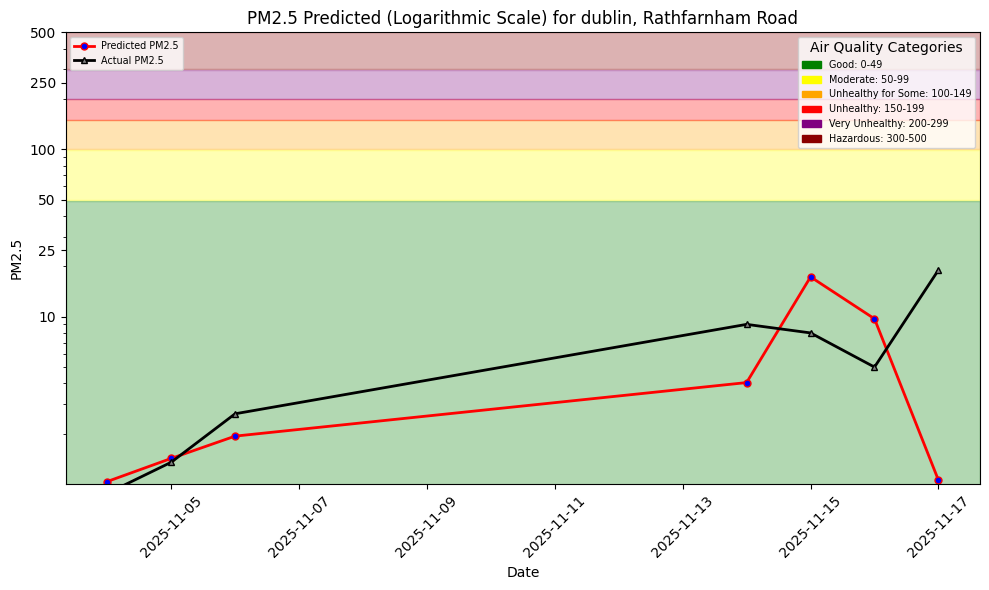

In [58]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [59]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/myuser/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/47191 ela…

Uploading /home/myuser/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|          | 0/6359…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272004/settings/fb/path/Resources/airquality


---